<a href="https://colab.research.google.com/github/Affanamin/AIchatbot/blob/master/TimeSeries_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [3]:
from google.colab import files
src = list(files.upload().values())[0]
open('download.py','wb').write(src)
#import weather

Saving download.py to download.py


4473

In [4]:
from google.colab import files
src = list(files.upload().values())[0]
open('weather.py','wb').write(src)
import weather

Saving weather.py to weather.py


In [5]:
weather.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [6]:
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

In [7]:

%%time
df = weather.load_resampled_data()

CPU times: user 1min 40s, sys: 7.09 s, total: 1min 47s
Wall time: 1min 48s


In [8]:
df.head()

Aalborg               ...   Roskilde            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 11:00:00  5.000000  1007.766667  ...  11.466667  280.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.466667  280.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.133333  278.333333
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.300000  270.000000
1980-03-01 15:00:00  4.000000  1008.200000  ...  12.300000  270.000000

[5 rows x 20 columns]

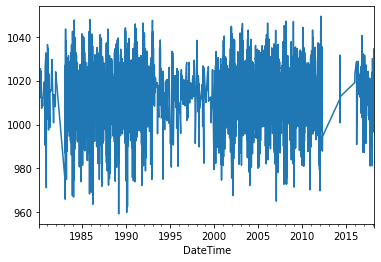

In [9]:
## EDA Starts Here
##Missing Data


df['Esbjerg']['Pressure'].plot();



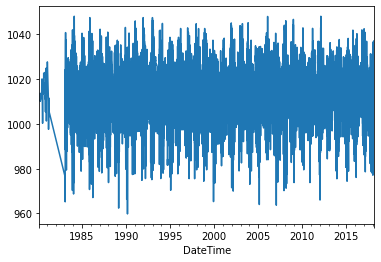

In [10]:
df['Roskilde']['Pressure'].plot();

In [11]:
df.values.shape

(333109, 20)

In [0]:
#Removing Columns
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

In [0]:
##ADD Data  -----------------------------------------------------------------------------------------------------

df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

In [14]:
df

Aalborg                         ...    Roskilde Various     
                         Temp     Pressure WindSpeed  ...     WindDir     Day Hour
DateTime                                              ...                         
1980-03-01 11:00:00  5.000000  1007.766667      10.2  ...  280.000000      61   11
1980-03-01 12:00:00  5.000000  1008.000000      10.3  ...  280.000000      61   12
1980-03-01 13:00:00  5.000000  1008.066667       9.7  ...  278.333333      61   13
1980-03-01 14:00:00  4.333333  1008.133333      11.1  ...  270.000000      61   14
1980-03-01 15:00:00  4.000000  1008.200000      11.3  ...  270.000000      61   15
...                       ...          ...       ...  ...         ...     ...  ...
2018-03-01 19:00:00 -4.400000  1024.200000       7.2  ...   60.000000      60   19
2018-03-01 20:00:00 -4.300000  1023.700000       6.7  ...   70.000000      60   20
2018-03-01 21:00:00 -3.900000  1023.100000       8.8  ...   60.000000      60   21
2018-03-01 22:00:00 -3.800000  1022.900000       7.2  ...   60.000000      60   22
2018-03-01 23:00:00 -4.200000  1022.500000       7.2  ...   60.000000      60   23

[333109 rows x 20 columns]

In [0]:
target_city = 'Odense'

In [0]:
target_names = ['Temp', 'Pressure']

In [0]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

In [0]:
df_targets = df[target_city][target_names].shift(-shift_steps)

In [19]:
df[target_city][target_names].head(shift_steps + 5)

,Temp,Pressure
DateTime,,
1980-03-01 11:00:00,6.142857,1011.066667
1980-03-01 12:00:00,7.000000,1011.200000
1980-03-01 13:00:00,7.000000,1011.300000
1980-03-01 14:00:00,6.857143,1011.400000
1980-03-01 15:00:00,6.000000,1011.500000
1980-03-01 16:00:00,4.909091,1011.688889
1980-03-01 17:00:00,3.953488,1011.877778
1980-03-01 18:00:00,3.674419,1012.066667
1980-03-01 19:00:00,3.395349,1012.255556


In [20]:

df_targets.tail()
df_targets.shape

(333109, 2)

In [21]:
#Coverting to numpy arrays

x_data = df.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)

y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

num_data = len(x_data)
num_data



<class 'numpy.ndarray'>
Shape: (333085, 20)
<class 'numpy.ndarray'>
Shape: (333085, 2)


333085

In [22]:

#Train test split
train_split = 0.9
num_train = int(train_split * num_data)
print(num_train)

#num_test = num_data - num_train
#print(num_test)

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print ("X_lenghts" , len(x_train) + len(x_test))

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
#len(y_train) + len(y_test)
print ("Y_lenghts" , len(y_train) + len(y_test))

num_x_signals = x_data.shape[1]
print(num_x_signals)

num_y_signals = y_data.shape[1]
print(num_y_signals)

299776
X_lenghts 333085
Y_lenghts 333085
20
2


In [0]:
##Data Scaling

x_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)



In [24]:


print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 20)
(299776, 2)


In [0]:
## Data Generator


def batch_generator(batch_size, sequence_length):
    """
    #Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [26]:

batch_size = 256
sequence_length = 24 * 7 * 8
sequence_length
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)
x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 2)


In [0]:
## We can plot one of the 20 input-signals as an example.

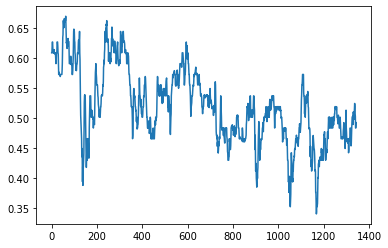

In [28]:

batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [0]:
#seq = y_batch[batch, :, signal]
#plt.plot(seq)

In [0]:
## Validation Set

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
## Create the Recurrent Neural Network
model = Sequential()

In [0]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
#model.add(GRU(units=512,
model.add(LSTM(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [0]:

if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [0]:
## Loss Function

warmup_steps = 50

def loss_mse_warmup(y_true, y_pred):
    """
    #Calculate the Mean Squared Error between y_true and y_pred,
    #but ignore the beginning "warmup" part of the sequences.
    
    #y_true is the desired output.
    #y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [36]:
## Compile Model

optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 512)         1091584   
_________________________________________________________________
dense (Dense)                (None, None, 2)           1026      
Total params: 1,092,610
Trainable params: 1,092,610
Non-trainable params: 0
_________________________________________________________________


In [0]:
## Callback Functions

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [0]:

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [0]:

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [42]:
## Train the Recurrent Neural Network

%%time
model.fit(x=generator,
          epochs=30,
          steps_per_epoch=150,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.0096
Epoch 00001: val_loss improved from inf to 0.00604, saving model to 23_checkpoint.keras
150/150 [==============================] - 77s 513ms/step - loss: 0.0096 - val_loss: 0.0060 - lr: 0.0010
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.0054
Epoch 00002: val_loss improved from 0.00604 to 0.00554, saving model to 23_checkpoint.keras
150/150 [==============================] - 76s 508ms/step - loss: 0.0054 - val_loss: 0.0055 - lr: 0.0010
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.0045
Epoch 00003: val_loss improved from 0.00554 to 0.00377, saving model to 23_checkpoint.keras
150/150 [==============================] - 76s 509ms/step - loss: 0.0045 - val_loss: 0.0038 - lr: 0.0010
Epoch 4/30
150/150 [==============================] - ETA: 0s - loss: 0.0040
Epoch 00004: val_loss improved from 0.00377 to 0.00345, saving model to 23_checkpoint.keras
150/150 [====

In [0]:
#Load Checkpoint


try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [44]:
## Performance on Test-Set
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 1ms/step - loss: 0.0026


In [45]:
print("loss (test-set):", result)

loss (test-set): 0.0025720279663801193


In [0]:

# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [0]:
## Generate Predictions¶
#This helper-function plots the predicted and true output-signals.

def plot_comparison(start_idx, length=100, train=True):
    """
    #Plot the predicted and true output-signals.
    
    #:param start_idx: Start-index for the time-series.
    #:param length: Sequence-length to process and plot.
    #:param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

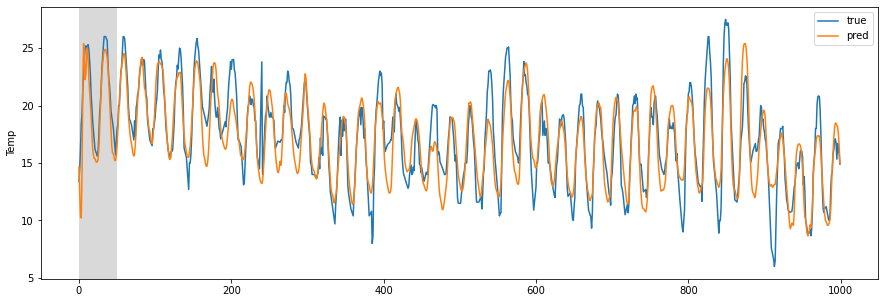

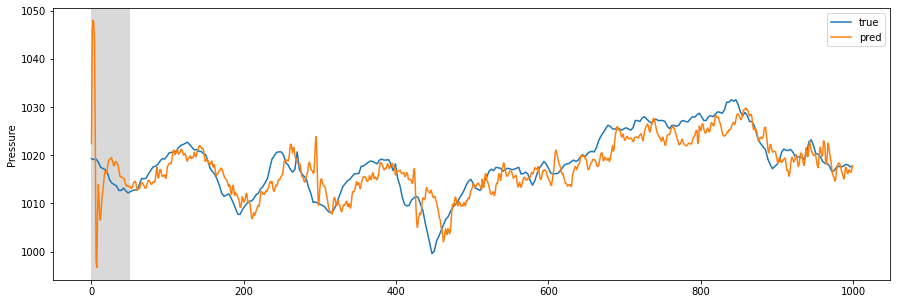

In [57]:
plot_comparison(start_idx=100000, length=1000, train=True)

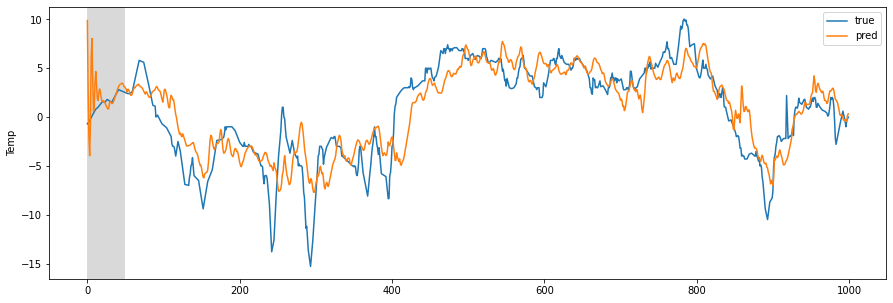

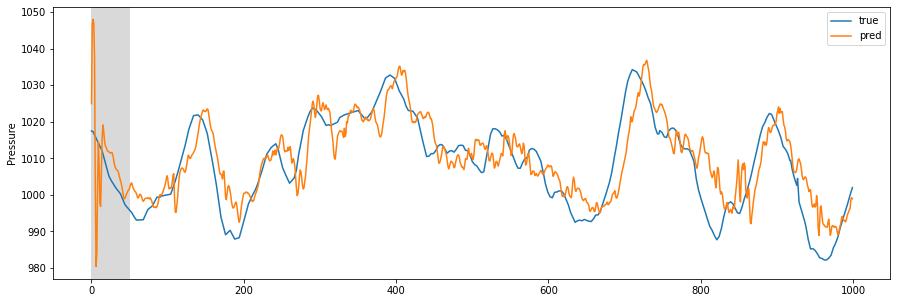

In [49]:
## Strange Example
### The following is another example from the training-set.


plot_comparison(start_idx=200000, length=1000, train=True)

In [0]:
#df['Odense']['Temp'][200000:200000+1000].plot();

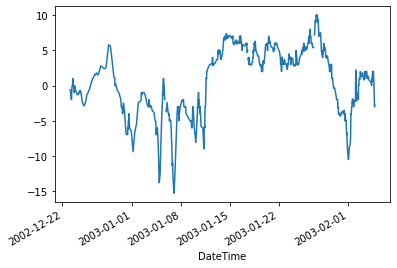

In [56]:
df_org = weather.load_original_data()
df_org.xs('Odense')['Temp']['2002-12-23':'2003-02-04'].plot();

In [0]:
## Example from Test-Set

#plot_comparison(start_idx=200, length=1000, train=False)

LINK:

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

Exercises
These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

1. You may want to backup this Notebook before making any changes.

2. Remove the wind-speed from the target-data. Does it improve prediction for the temperature and pressure?

3. Train for more epochs, possibly with a lower learning-rate. Does it improve the performance on the test-set?

4. Try a different architecture for the neural network, e.g. higher or lower state-size for the GRU layer, more GRU layers, dense layers before and after the GRU layers, etc.


5. Use hyper-parameter optimization from Tutorial #19.

6. Try using longer and shorter sequences for the batch-generator.

7. Try and remove the city "Odense" from the input-signals.

8. Try and add last year's weather-data to the input-signals.

9. How good is the model at predicting the weather 3 or 7 days into the future?

10. Can you train a single model with the output-signals for multiple time-shifts, so that a single model predicts the weather in e.g. 1, 3 and 7 days.



Explain to a friend how the program works.